In [103]:
# MODEL OF WHICH YOU WANT TO USE
training_path = "./training/20220419-215928"
MODEL_NAME = "YAMNET"
DENSE_UNITS = 640
PATCH_HOP_DISTANCE = 0.25
FLATMAP_TESTSET = False # Whether or not to flatmap the test_set

# Other settings 
DATASET_DIR = "./datasets/cer_dataset_16k_resampled_split/"
SEED = 1
FILE_RATIO = 1

import datetime
import os, sys, glob
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import random
# import datetime
DATETIME_NOW = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
sys.path.append('src')
from models.get_models import get_model
import models.yamnet_tf2.params as params
params = params.Params(sample_rate=16000, patch_hop_seconds=PATCH_HOP_DISTANCE) # 0.25

# from dataload_utils.data_load import get_dataset, get_filenames_and_classnames_list
import dataload_utils.data_load as data_load
from dataload_utils.data_aug import mix_up

# SEED = 42
random.seed(SEED)
tf.random.set_seed(SEED)

dataset_loader = data_load.Dataset_loader(DATASET_DIR, params)
filenames_all = dataset_loader.__filenames_all__
classes = dataset_loader.__classes__
num_classes = dataset_loader.__num_classes__
print("classes: {}, num_classes: {}".format(classes, num_classes))

AUTOTUNE = tf.data.AUTOTUNE
random.shuffle(filenames_all)
filenames_all=filenames_all[:int(len(filenames_all)*FILE_RATIO)]
filenames_test = filenames_all[int(len(filenames_all)*0.9):]

batch_size=64
test_dataset = dataset_loader.get_dataset(filenames_test, augment=False, flat_map=FLATMAP_TESTSET).shuffle(batch_size*2)#.batch(batch_size)
test_dataset = test_dataset.cache().prefetch(AUTOTUNE)

# Declare model
model = get_model(MODEL_NAME, dense_units = DENSE_UNITS)
model.summary()

model_training_path = training_path + "/{}".format(MODEL_NAME)
ckp_path = model_training_path + "/checkpoints/cp.ckpt"

# Evaluate performance of model with test fold (that it wasn't trained on)
model.load_weights(ckp_path)


Number of files in Class_00_Modified_car_engines: 4644
Number of files in Class_01_Regular_Vehicles: 9539
Number of files in Class_02_Tools_and_Mechanisms: 13307
Number of files in Class_03_Environmental_Sounds: 10488
Number of files:  37978
classes: ['Class_00_Modified_car_engines', 'Class_01_Regular_Vehicles', 'Class_02_Tools_and_Mechanisms', 'Class_03_Environmental_Sounds'], num_classes: 4
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 96, 64, 1)]       0         
                                                                 
 layer1/conv (Conv2D)        (None, 48, 32, 32)        288       
                                                                 
 layer1/conv/bn (BatchNormal  (None, 48, 32, 32)       96        
 ization)                                                        
                                                           

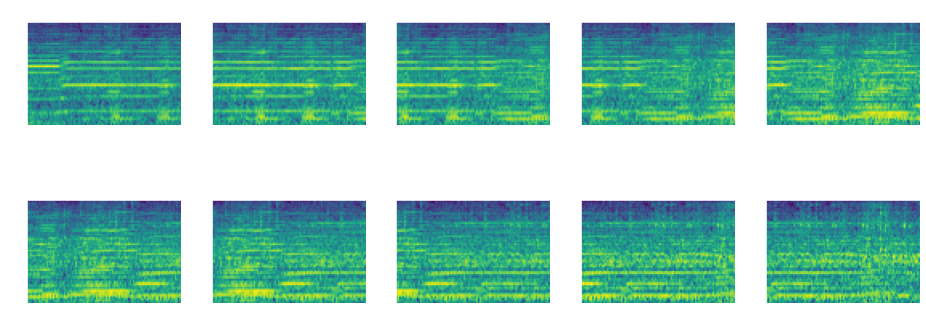

In [61]:
# Checkign features
# You can re-run this cell and it should reshuffle and fetch you new samples
import matplotlib.pyplot as plt
params = {"ytick.color" : "w", "xtick.color" : "w", "axes.labelcolor" : "w", "text.color" : "w"}
plt.rcParams.update(params)

for sample, label in test_dataset.take(1):
    rows = int(len(sample)//5)
    if rows == 0: rows=1
    fig, ax = plt.subplots(rows, 5, figsize=(16,rows*3))
    ax = ax.flatten()
    for i, feature in zip(range(rows*5), sample):
        ax[i].imshow(tf.transpose(feature, [1, 0, 2]), origin='lower')
        ax[i].set_title("Segment {}".format(i))

Testing accuracy:  0.91


Text(0.5, 1.0, 'YAMNET, Acc: 0.910000')

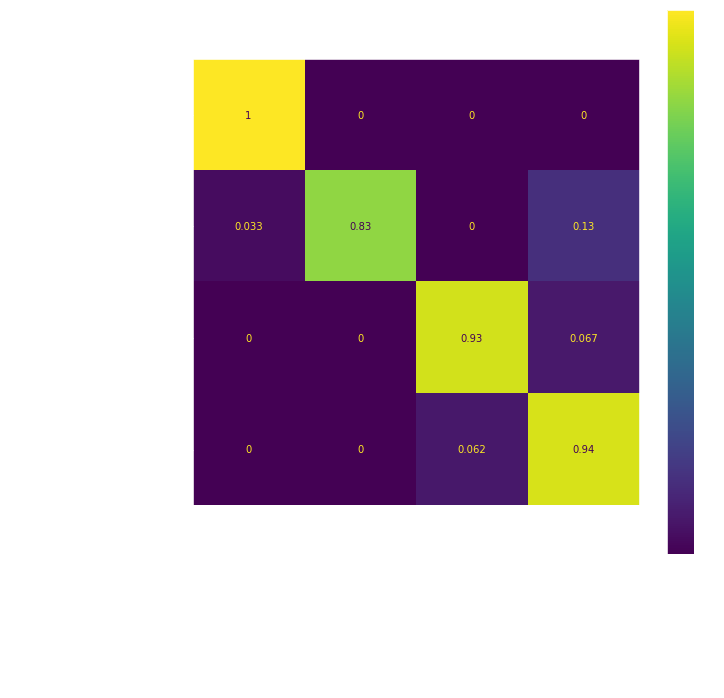

In [104]:
# loss, acc = model.evaluate(test_dataset, verbose=2)

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from statistics import mode
# Get y_preds = predictions made by model
y_preds,y_trues = [],[]
for x_test, y_true in list(test_dataset.take(100)):
    if FLATMAP_TESTSET == True:
        y_pred = np.argmax(model.predict(x_test), axis=1) # use this instead if flat_mapped
        y_true = np.argmax(y_true, axis=1)
    else:
        y_pred = np.argmax(model.predict(x_test), axis=1)
        y_pred = [mode(y_pred)] # Take mode of predictions (averaged score over multiple features in segment)
        y_true = [np.argmax(y_true, axis=1)[0]] # Take only one (they're all the same label in segment)
        
    y_preds.extend(y_pred)
    y_trues.extend(y_true)
y_trues = np.array(y_trues)

y_preds = np.array(y_preds)

accuracy = accuracy_score(y_trues, y_preds)
print("Testing accuracy: ", accuracy)


cm, ax = plt.subplots(figsize=(10,10))
try:
    cm = ConfusionMatrixDisplay.from_predictions(
        y_trues, y_preds, normalize='true', 
        display_labels=classes, xticks_rotation=90,
        ax=ax
    )
except:
    cm = ConfusionMatrixDisplay.from_predictions(
        y_trues, y_preds, normalize='true', 
        xticks_rotation=90,
        ax=ax
    )
ax.set_title("{}, Acc: {:02f}".format(model_training_path.split("/")[-1], accuracy))